### Required Imports and Installations

In [1]:
#!pip install xgboost
#!pip install yellowbrick
#!pip install ipywidgets
#!pip install pandas-profiling

#!jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

from scipy.stats import kendalltau, pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import xgboost
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

### Data Ingestion & Pre-Processing

In [3]:
con_evs = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-EVs.sqlite"))
con_game = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Gaming.sqlite"))
con_oil = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Oil.sqlite"))
con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech.sqlite"))
con_pnf = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-PnF.sqlite"))
con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-stock.sqlite"))
con_res = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))


cons = {
    "EVs": con_evs,
    "Gaming": con_game,
    "Oil": con_oil,
    "Tech": con_tech,
    "Pharma": con_pnf,
    "Food": con_pnf,
    "Stock": con_stock,
    "Results": con_res
}

In [4]:
tickers = {
    "EVs": ["TSLA", "LCID"],
    "Oil": ["COP", "XOM", "CVX"],
    "Pharma": ["PFE", "AZN", "MRNA"],
    "Food": ["MCD", "MDLZ", "PEP"],
    "Tech": ["GOOGL", "AAPL", "INTC"]
}

categories = ["EVs", "Oil", "Tech", "Pharma", "Food"]

#"Gaming": ["EA"]

#"Gaming": ["EA", "ATVI"],
#"Oil": ["COP", "XOM", "CVX", "ENB"],
#"Tech": ["GOOGL", "AAPL", "MSFT", "INTC"]

In [5]:
def load_datasets(cons, tickers, categories, reduce = False):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            if reduce == True:
                tweet_df = pd.read_sql_query(f"SELECT * from processed_tweets WHERE category='{category}'", cons["Results"])
                
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")

                tweet_df.sort_values(by=['date'])

                aggregate_dict = dict()

                for idx, row in tweet_df.iterrows():
                    key = f"{row['category']},{row['date']}"

                    if key in aggregate_dict:
                        aggregate_dict[key] = aggregate_dict[key] + row

                    else:
                        aggregate_dict[key] = row


                aggregate_dict_df = pd.DataFrame.from_dict(aggregate_dict, orient='index')   
                aggregate_dict_df.reset_index(drop=True, inplace=True)   
                aggregate_dict_df['date'] = aggregate_dict_df['date'].str.slice(0, 10)

                #print(aggregate_dict_df.head())

                aggregate_dict_df.drop(columns = ['category', 'ticker'], inplace=True)
                aggregate_dict_df["date"] = aggregate_dict_df["date"].astype("datetime64")

                tweet_dfs[ticker] = aggregate_dict_df.copy(deep=True)
                
            else:
                tweet_df = pd.read_sql_query(f"SELECT * from new_scored_tweets WHERE category='{category}'", cons["Results"])

                tweet_df = tweet_df.drop(columns = ['category'])
                tweet_df["date"] = tweet_df["date"].astype("datetime64")
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                
                tweet_dfs[ticker] = tweet_df.copy(deep=True)
            
            stock_df = pd.read_sql_query(f"SELECT * from stock_data WHERE ticker='{ticker}'", cons["Stock"])
            
            stock_df = stock_df.drop(columns = ['category', 'ticker'])

            stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
            stock_df["open"] = stock_df["open"].astype("float64")
            stock_df["close"] = stock_df["close"].astype("float64")
            stock_df["high"] = stock_df["high"].astype("float64")
            stock_df["low"] = stock_df["low"].astype("float64")

            stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
            
            stock_dfs[ticker] = stock_df.copy(deep=True)
            
            del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [6]:
tweet_dfs, stock_dfs = load_datasets(cons, tickers, categories, reduce = False)

In [7]:
a = tweet_dfs["PFE"]

a

,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-05-01,49,3.394147,19.054670,8.551181,5.133044,32.563696,11.303259,2,42,5
1,2020-05-02,153,4.107121,11.978115,7.914763,31.609647,62.057818,59.332536,19,75,59
2,2020-05-03,214,4.326110,16.570904,6.102986,45.973912,136.154351,31.871733,40,151,23
3,2020-05-04,303,6.358850,14.657456,8.983693,24.655479,138.407129,139.937400,14,87,202
4,2020-05-05,247,8.042095,29.532238,25.425673,23.692399,138.137275,85.170316,17,146,84
...,...,...,...,...,...,...,...,...,...,...,...
737,2022-05-08,252,39.448318,28.093342,11.458338,148.087814,77.174197,26.737990,163,73,16
738,2022-05-09,759,13.576670,39.901554,20.521774,605.682513,117.988265,35.329296,645,85,29
739,2022-05-10,307,23.732765,77.217316,36.049919,65.486871,176.064004,65.449125,47,211,49
740,2022-05-11,132,11.154416,18.798464,12.047116,79.391982,37.218640,15.389381,100,18,14


In [8]:
b = stock_dfs["PFE"]

b

,date,open,close,high,low
0,2020-05-13,37.3100,37.0500,37.42500,36.58500
1,2020-05-14,36.8000,37.9200,37.96000,36.78000
2,2020-05-15,37.9600,37.7600,38.17000,37.38500
3,2020-05-16,38.1500,37.9150,38.31500,37.50750
4,2020-05-17,38.2450,37.9925,38.38750,37.56875
...,...,...,...,...,...
725,2022-05-08,48.3075,48.7400,49.18125,47.83750
726,2022-05-09,48.3800,48.6400,49.17000,47.77000
727,2022-05-10,49.0400,49.4900,49.90000,48.68500
728,2022-05-11,49.0700,49.4500,50.23500,49.03000


In [9]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
            temp_stock_df = stock_dfs[ticker].copy(deep=True)

            temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
            temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
            
            
            merged_dfs[ticker] = temp_merged_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
            
            del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [10]:
def normalize_datasets(categories, tickers, merged_dfs, reduced = False):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_norm_df = merged_dfs[ticker].copy(deep=True)
            
            temp_norm_df = temp_norm_df.drop(columns=['date'])

            temp_norm_df = scaler.fit_transform(temp_norm_df)
            
            if reduced == False: #For the complete datasets
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                      'count','ind_neg','ind_neu', 'ind_pos', \
                                                                      'wted_neg', 'wted_neu', 'wted_pos', \
                                                                      'neg_counts', 'neu_counts', 'pos_counts'])
                
            else: #For the reduced datasets
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = ['prev_open', 'ind_neg', \
                                                                    'ind_neu', 'ind_pos', 'close'])
            
            norm_dfs[ticker] = temp_norm_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
            
            del temp_norm_df
            
    return norm_dfs

In [11]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (717, 15) 

Data dimensions for LCID: (242, 15) 

Data dimensions for COP: (717, 15) 

Data dimensions for XOM: (717, 15) 

Data dimensions for CVX: (717, 15) 

Data dimensions for GOOGL: (714, 15) 

Data dimensions for AAPL: (714, 15) 

Data dimensions for INTC: (717, 15) 

Data dimensions for PFE: (730, 15) 

Data dimensions for AZN: (730, 15) 

Data dimensions for MRNA: (730, 15) 

Data dimensions for MCD: (730, 15) 

Data dimensions for MDLZ: (730, 15) 

Data dimensions for PEP: (730, 15) 



In [12]:
norm_dfs = normalize_datasets(categories, tickers, merged_dfs, reduced = False)

Data dimensions for TSLA: (717, 14) 

Data dimensions for LCID: (242, 14) 

Data dimensions for COP: (717, 14) 

Data dimensions for XOM: (717, 14) 

Data dimensions for CVX: (717, 14) 

Data dimensions for GOOGL: (714, 14) 

Data dimensions for AAPL: (714, 14) 

Data dimensions for INTC: (717, 14) 

Data dimensions for PFE: (730, 14) 

Data dimensions for AZN: (730, 14) 

Data dimensions for MRNA: (730, 14) 

Data dimensions for MCD: (730, 14) 

Data dimensions for MDLZ: (730, 14) 

Data dimensions for PEP: (730, 14) 



In [13]:
merged_dfs['PFE'].head()

,date,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-05-13,37.310,37.0500,37.4250,36.58500,188,6.760271,20.023743,12.215987,21.947857,111.650433,54.401711,14,133,41
1,2020-05-14,36.800,37.9200,37.9600,36.78000,201,3.785908,21.640482,11.573608,18.831130,117.376116,64.792756,21,128,52
2,2020-05-15,37.960,37.7600,38.1700,37.38500,393,12.132028,34.384533,22.483440,35.887855,262.136906,94.975219,34,297,62
3,2020-05-16,38.150,37.9150,38.3150,37.50750,197,3.652356,15.221085,5.126558,22.649830,130.891075,43.459093,11,168,18
4,2020-05-17,38.245,37.9925,38.3875,37.56875,167,5.574669,14.228289,8.197043,24.327645,112.032076,30.640279,18,138,11


In [14]:
norm_dfs['PFE'].head()

,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,0.182520,0.171517,0.174822,0.176293,0.021396,0.075648,0.126722,0.120675,0.006502,0.023409,0.017838,0.003617,0.018738,0.041794
1,0.164619,0.201301,0.193000,0.183203,0.022883,0.042321,0.137053,0.114287,0.005576,0.024619,0.021250,0.005425,0.018033,0.053007
2,0.205335,0.195823,0.200136,0.204642,0.044851,0.135838,0.218487,0.222783,0.010641,0.055208,0.031161,0.008783,0.041843,0.063201
3,0.212004,0.201130,0.205063,0.208983,0.022426,0.040824,0.096033,0.050172,0.006710,0.027475,0.014244,0.002842,0.023669,0.018349
4,0.215339,0.203783,0.207526,0.211153,0.018993,0.062363,0.089689,0.080707,0.007208,0.023490,0.010035,0.004650,0.019442,0.011213


In [15]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        for ticker in tickers[category]:
            plt.figure(figsize=(10,6))
            sns.heatmap(norm_dfs[ticker].corr('pearson'),cmap=random.choice(cmaps),annot=True)
            plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)
            plt.show()

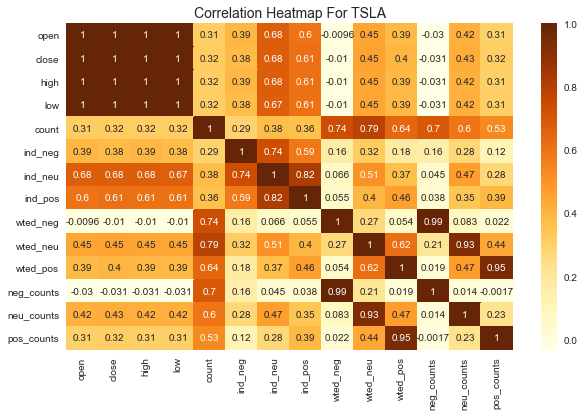

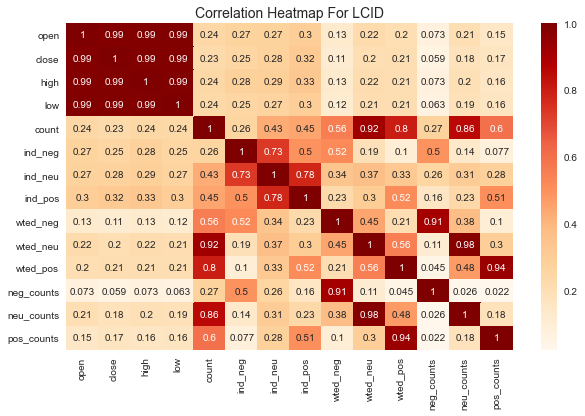

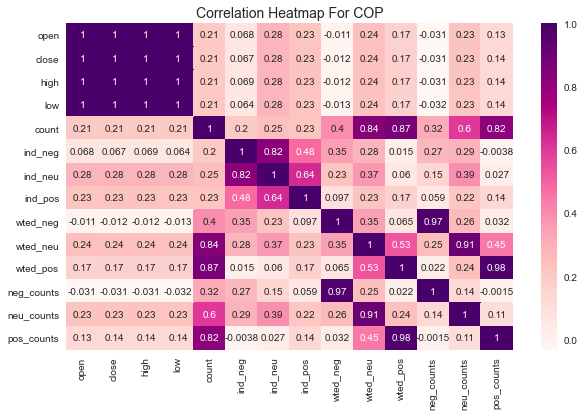

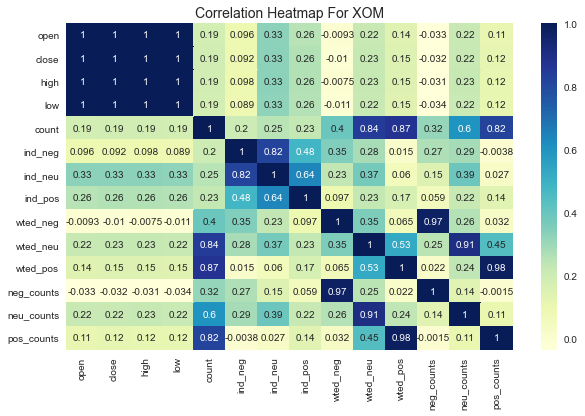

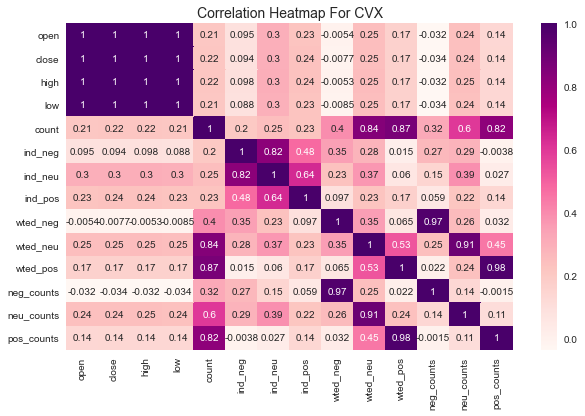

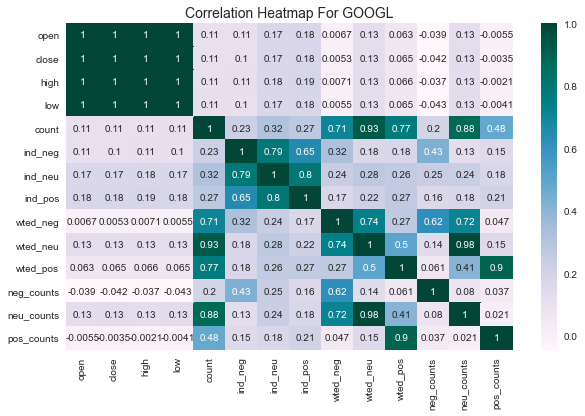

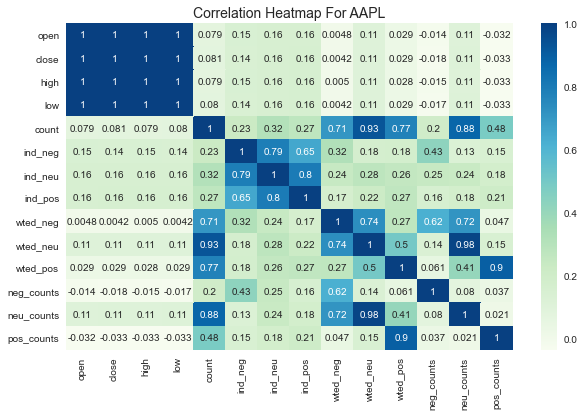

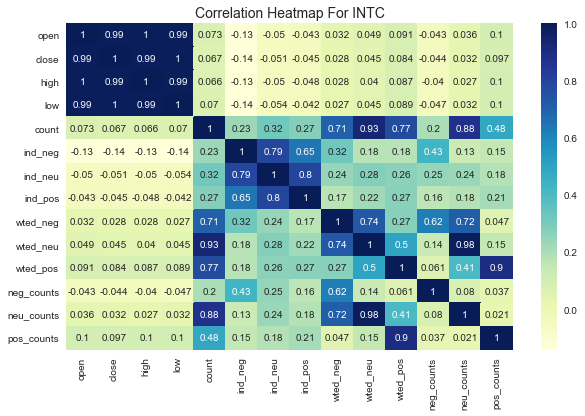

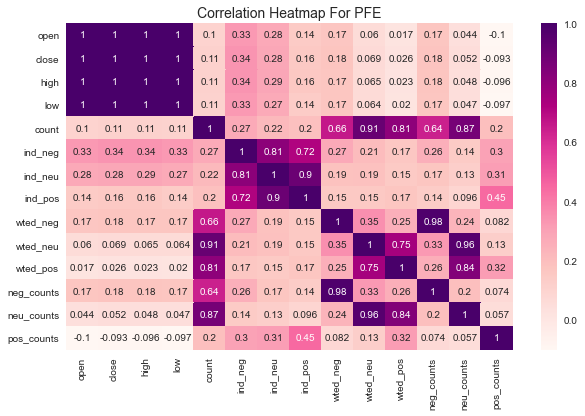

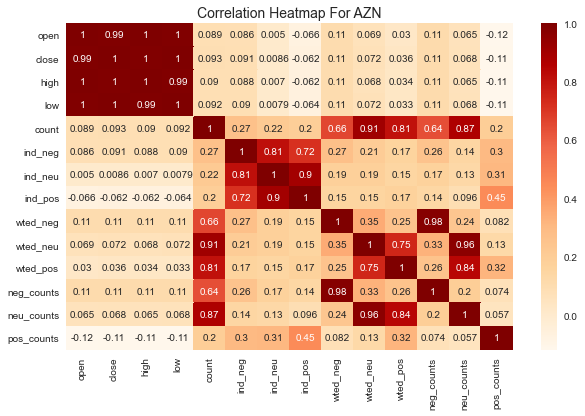

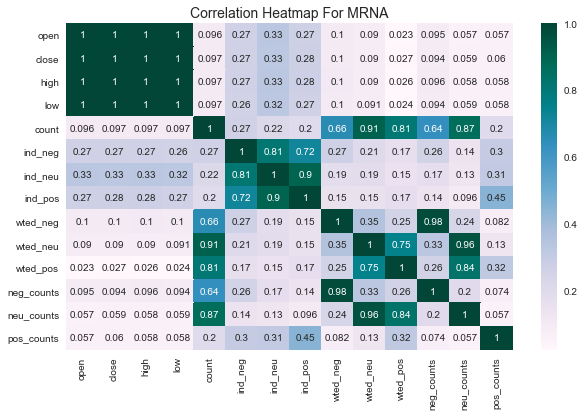

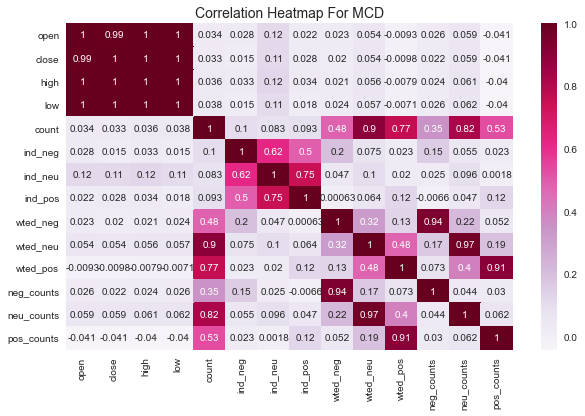

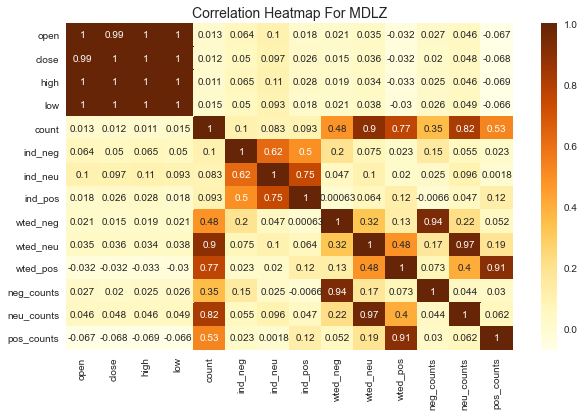

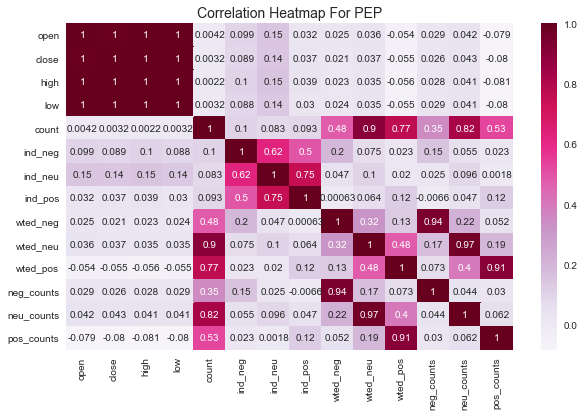

In [16]:
plot_corr_heatmaps(categories, tickers, norm_dfs)

In [17]:
#To determine the confidence levels for the correlated columns found in the correlation heatmaps

def calc_pearson_r(categories, tickers, norm_dfs):
    """
    To calculate the Pearson's correlation coefficient and determine confidence level (p > 0.05)
    """
    for category in categories:
        for ticker in tickers[category]:
            print(f"{ticker}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_neg'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_NEG - ρ: {rho}, P: {p}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_neu'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_NEU - ρ: {rho}, P: {p}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_pos'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_POS - ρ: {rho}, P: {p}")
            print("\n")
            
calc_pearson_r(categories, tickers, norm_dfs)

TSLA
	=====> IND_NEG - ρ: 0.3823323787182139, P: 2.2518576476764875e-26
	=====> IND_NEU - ρ: 0.6768830315257676, P: 3.156927994514375e-97
	=====> IND_POS - ρ: 0.6147949325585085, P: 9.370512803272214e-76


LCID
	=====> IND_NEG - ρ: 0.253043015120937, P: 6.861828060328372e-05
	=====> IND_NEU - ρ: 0.2760508645916776, P: 1.3181543405915005e-05
	=====> IND_POS - ρ: 0.31837515366033636, P: 4.2062976687391716e-07


COP
	=====> IND_NEG - ρ: 0.06695913422737615, P: 0.0731589077845027
	=====> IND_NEU - ρ: 0.2799083967145156, P: 2.2559852817766692e-14
	=====> IND_POS - ρ: 0.23316048651419055, P: 2.6204497462848273e-10


XOM
	=====> IND_NEG - ρ: 0.092040140157602, P: 0.013682960281732458
	=====> IND_NEU - ρ: 0.330317493421954, P: 1.0305348674081716e-19
	=====> IND_POS - ρ: 0.26330842170450536, P: 7.773831064470306e-13


CVX
	=====> IND_NEG - ρ: 0.09367266515760307, P: 0.012093555647539899
	=====> IND_NEU - ρ: 0.30090892972890143, P: 1.7963773768977438e-16
	=====> IND_POS - ρ: 0.23630946726845872,

In [18]:
def add_prev_day_open(merged_dfs):
    prev_open_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
    
            t_df = merged_dfs[ticker].copy(deep = True)
            t_df = t_df.drop(columns = ['high', 'low', 'count', 'wted_neg', 'wted_neu', 'wted_pos', \
                                       'neg_counts', 'neu_counts', 'pos_counts'])

            t_minus1_df = t_df.copy(deep = True).drop(columns = ['close', 'ind_neg', 'ind_neu', 'ind_pos'])

            t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

            t_df = t_df.drop(columns=['open'])

            prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

            prev_open_df = prev_open_df[['date', 'open', 'ind_neg', 'ind_neu', 'ind_pos', 'close']]

            prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open'})
            
            prev_open_dfs[ticker] = prev_open_df
            
            del prev_open_df #Perform GC

    return prev_open_dfs

In [19]:
prev_open_dfs = add_prev_day_open(merged_dfs)

prev_open_dfs['PFE']

,date,prev_open,ind_neg,ind_neu,ind_pos,close
0,2020-05-14,37.3100,3.785908,21.640482,11.573608,37.9200
1,2020-05-15,36.8000,12.132028,34.384533,22.483440,37.7600
2,2020-05-16,37.9600,3.652356,15.221085,5.126558,37.9150
3,2020-05-17,38.1500,5.574669,14.228289,8.197043,37.9925
4,2020-05-18,38.2450,18.104982,73.549225,53.345791,38.0700
...,...,...,...,...,...,...
724,2022-05-08,48.2350,39.448318,28.093342,11.458338,48.7400
725,2022-05-09,48.3075,13.576670,39.901554,20.521774,48.6400
726,2022-05-10,48.3800,23.732765,77.217316,36.049919,49.4900
727,2022-05-11,49.0400,11.154416,18.798464,12.047116,49.4500


In [20]:
prev_open_norm_dfs = normalize_datasets(categories, tickers, prev_open_dfs, reduced = True)

Data dimensions for TSLA: (716, 5) 

Data dimensions for LCID: (241, 5) 

Data dimensions for COP: (716, 5) 

Data dimensions for XOM: (716, 5) 

Data dimensions for CVX: (716, 5) 

Data dimensions for GOOGL: (713, 5) 

Data dimensions for AAPL: (713, 5) 

Data dimensions for INTC: (716, 5) 

Data dimensions for PFE: (729, 5) 

Data dimensions for AZN: (729, 5) 

Data dimensions for MRNA: (729, 5) 

Data dimensions for MCD: (729, 5) 

Data dimensions for MDLZ: (729, 5) 

Data dimensions for PEP: (729, 5) 



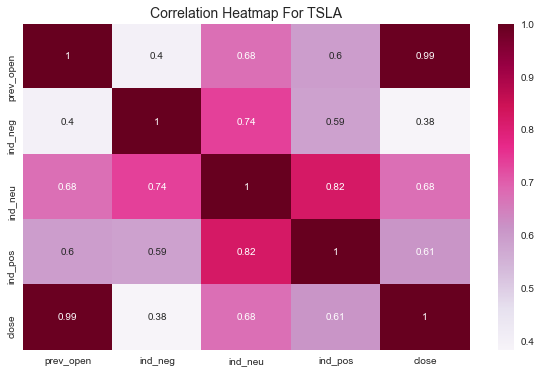

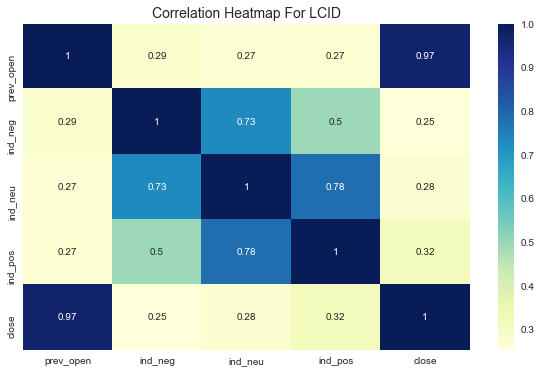

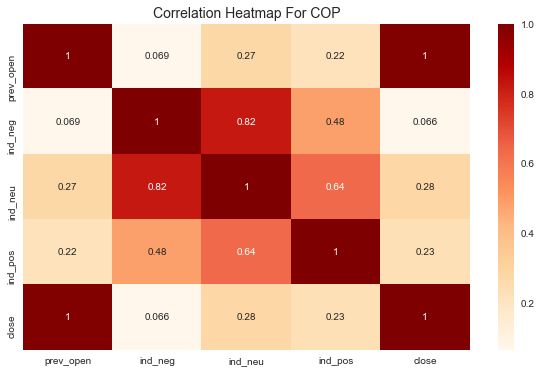

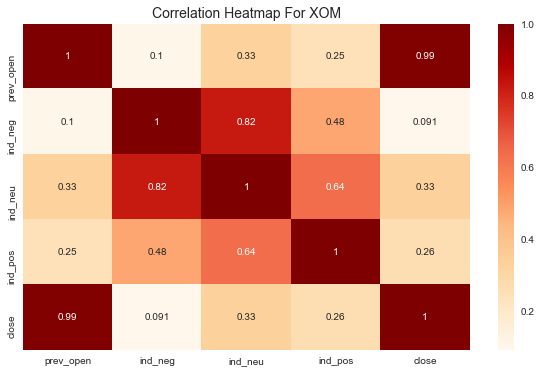

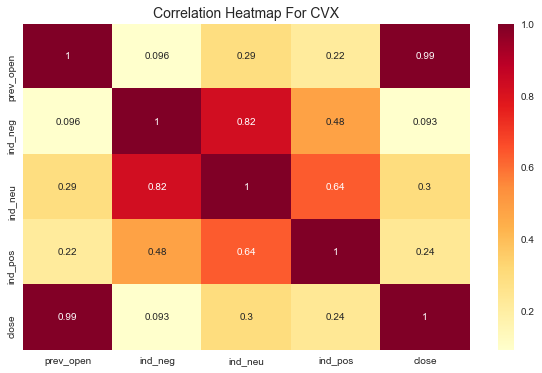

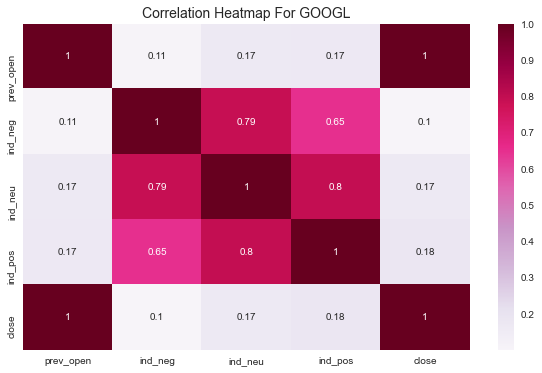

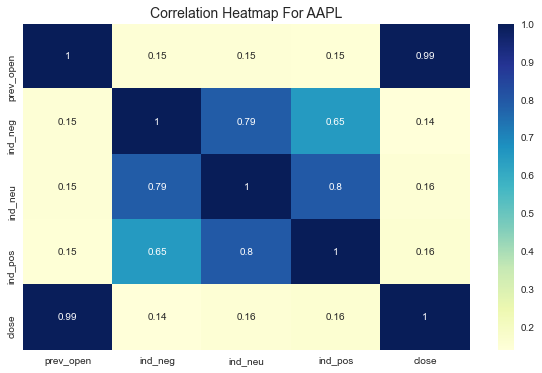

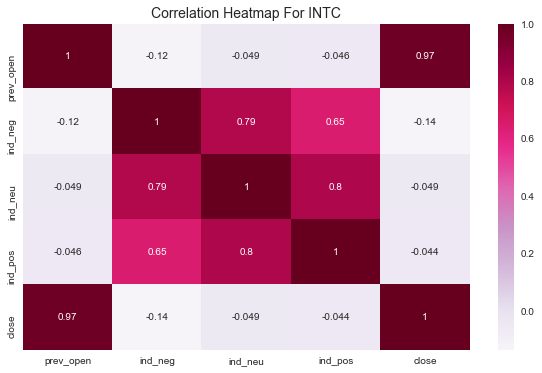

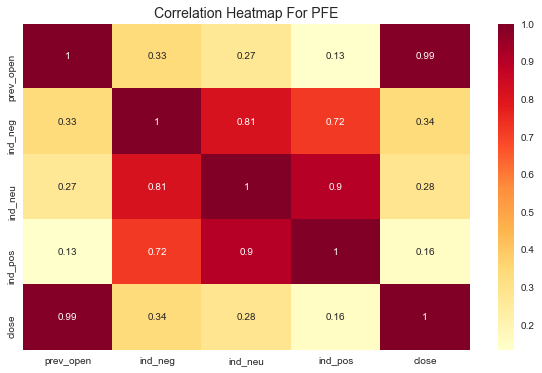

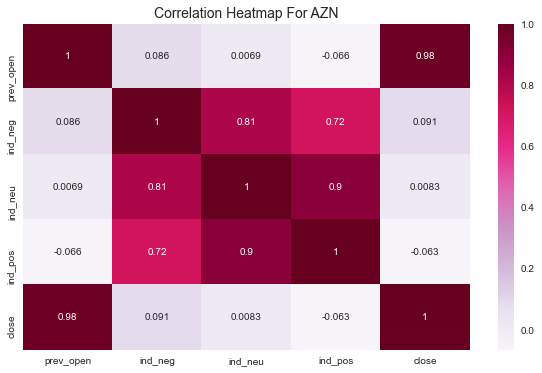

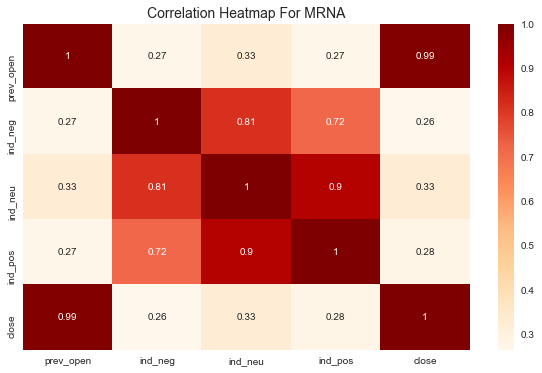

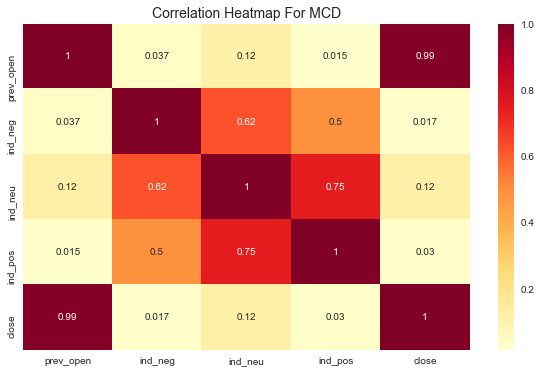

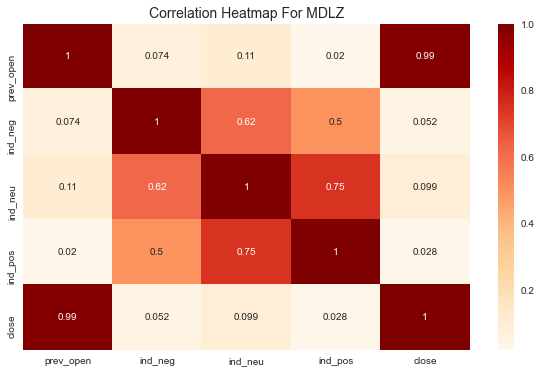

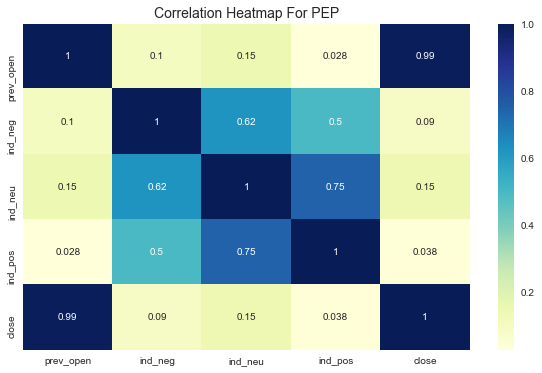

In [21]:
plot_corr_heatmaps(categories, tickers, prev_open_norm_dfs)

In [22]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [23]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    # predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [24]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.plot(predicted, color = 'green', label = 'Predicted Stock Price')
    plt.plot(test_label, color = 'red', label = 'Real Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [25]:
def get_train_test_set(norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = ['close'], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test

In [26]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [27]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels):
    model = XGBRegressor(max_depth=3, n_estimators=500, n_jobs=2,
                        objective='reg:squaredlogerror', booster='dart',
                        random_state=3, learning_rate=0.05, colsample_bytree=1, eval_metric='mae')

    
    for category in categories:
        for ticker in tickers[category]:
            print(f"======CURRENTLY WORKING ON {ticker}======")
            
            X_train, X_test, y_train, y_test = get_train_test_set(norm_dfs[ticker], output_label='close')
            
            model.fit(X_train, y_train)
            
            print_metrics(model, X_train, X_test, y_test)
            plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker])
            
            print(f"======FINISHED WORKING ON {ticker}======")

In [28]:
# """ 
# ONLY ind_neg, ind_neu, ind_pos
# Best Parameters: {'booster': 'gbtree', 'colsample_bytree': 0.7, 'eval_metric': 'mae', 
# 'learning_rate': 0.005, 'max_depth': 12, 'n_estimators': 100, 'objective': 'reg:squarederror'}
# """

In [29]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, prev_open_dfs, output_label='close')

======CURRENTLY WORKING ON TSLA======
RMSE:			0.052009
MSE:			0.002705
MAE:			0.042888
R2 Score:		0.750598
Adj. R2 Score:		0.748839
Exp. Variance Score:	0.765057
Max Error:		0.153516


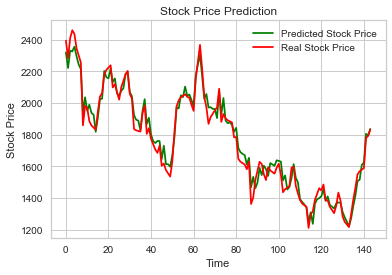

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON LCID======
RMSE:			0.055630
MSE:			0.003095
MAE:			0.045412
R2 Score:		-0.060119
Adj. R2 Score:		-0.082796
Exp. Variance Score:	0.246634
Max Error:		0.134128


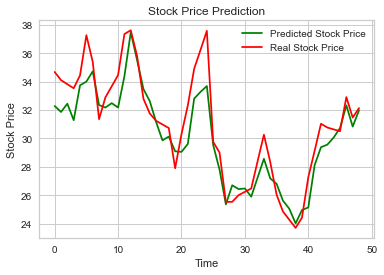

======FINISHED WORKING ON LCID======
======CURRENTLY WORKING ON COP======
RMSE:			0.173580
MSE:			0.030130
MAE:			0.126500
R2 Score:		-0.513047
Adj. R2 Score:		-0.523721
Exp. Variance Score:	0.138811
Max Error:		0.399505


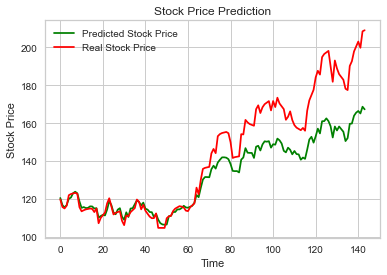

======FINISHED WORKING ON COP======
======CURRENTLY WORKING ON XOM======
RMSE:			0.188147
MSE:			0.035399
MAE:			0.136159
R2 Score:		-0.561416
Adj. R2 Score:		-0.572431
Exp. Variance Score:	0.209714
Max Error:		0.435178


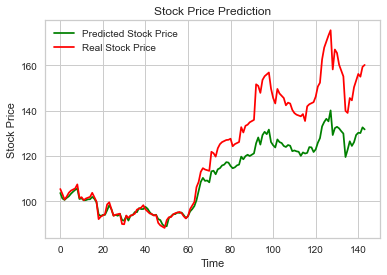

======FINISHED WORKING ON XOM======
======CURRENTLY WORKING ON CVX======
RMSE:			0.235143
MSE:			0.055292
MAE:			0.162668
R2 Score:		-1.060556
Adj. R2 Score:		-1.075092
Exp. Variance Score:	-0.081272
Max Error:		0.597163


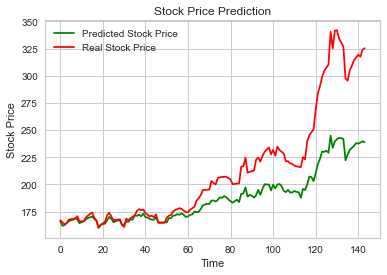

======FINISHED WORKING ON CVX======
======CURRENTLY WORKING ON GOOGL======
RMSE:			0.040561
MSE:			0.001645
MAE:			0.033231
R2 Score:		0.711270
Adj. R2 Score:		0.709226
Exp. Variance Score:	0.729736
Max Error:		0.109281


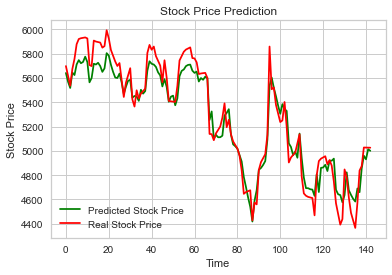

======FINISHED WORKING ON GOOGL======
======CURRENTLY WORKING ON AAPL======
RMSE:			0.141244
MSE:			0.019950
MAE:			0.121737
R2 Score:		-2.236317
Adj. R2 Score:		-2.259229
Exp. Variance Score:	0.140931
Max Error:		0.276274


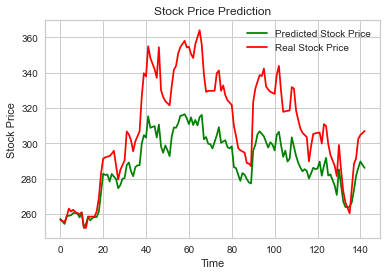

======FINISHED WORKING ON AAPL======
======CURRENTLY WORKING ON INTC======
RMSE:			0.046838
MSE:			0.002194
MAE:			0.034912
R2 Score:		0.809014
Adj. R2 Score:		0.807666
Exp. Variance Score:	0.810414
Max Error:		0.161602


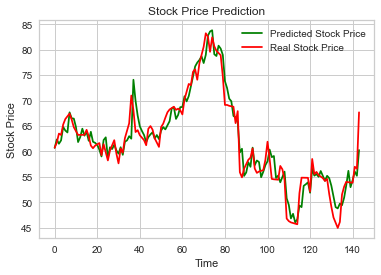

======FINISHED WORKING ON INTC======
======CURRENTLY WORKING ON PFE======
RMSE:			0.051857
MSE:			0.002689
MAE:			0.041156
R2 Score:		0.807916
Adj. R2 Score:		0.806587
Exp. Variance Score:	0.808025
Max Error:		0.153818


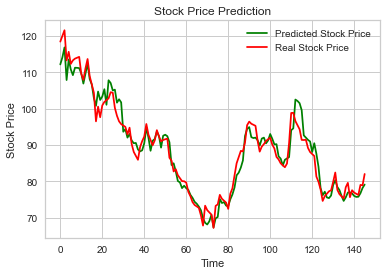

======FINISHED WORKING ON PFE======
======CURRENTLY WORKING ON AZN======
RMSE:			0.129246
MSE:			0.016705
MAE:			0.089454
R2 Score:		0.458548
Adj. R2 Score:		0.454801
Exp. Variance Score:	0.644630
Max Error:		0.381035


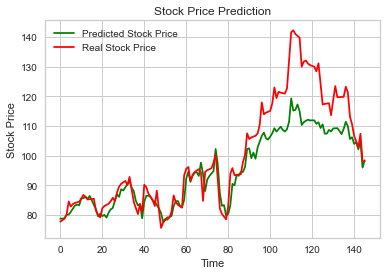

======FINISHED WORKING ON AZN======
======CURRENTLY WORKING ON MRNA======
RMSE:			0.032641
MSE:			0.001065
MAE:			0.022663
R2 Score:		0.856262
Adj. R2 Score:		0.855267
Exp. Variance Score:	0.867806
Max Error:		0.147333


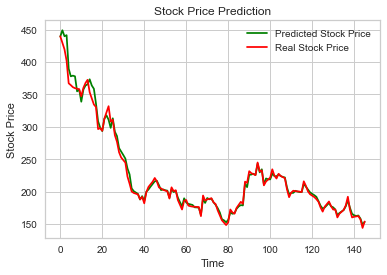

======FINISHED WORKING ON MRNA======
======CURRENTLY WORKING ON MCD======
RMSE:			0.043850
MSE:			0.001923
MAE:			0.034782
R2 Score:		0.852740
Adj. R2 Score:		0.851720
Exp. Variance Score:	0.852799
Max Error:		0.137377


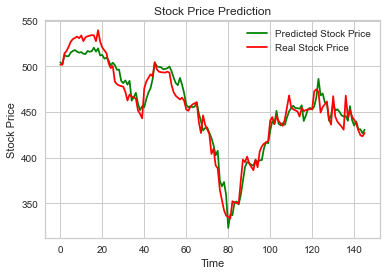

======FINISHED WORKING ON MCD======
======CURRENTLY WORKING ON MDLZ======
RMSE:			0.103835
MSE:			0.010782
MAE:			0.085407
R2 Score:		0.202329
Adj. R2 Score:		0.196808
Exp. Variance Score:	0.561772
Max Error:		0.221976


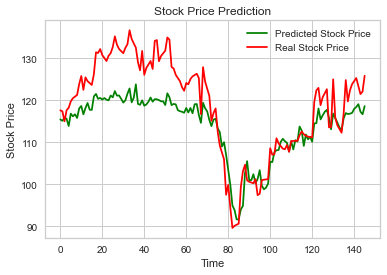

======FINISHED WORKING ON MDLZ======
======CURRENTLY WORKING ON PEP======
RMSE:			0.061193
MSE:			0.003745
MAE:			0.051590
R2 Score:		0.617957
Adj. R2 Score:		0.615313
Exp. Variance Score:	0.741714
Max Error:		0.150254


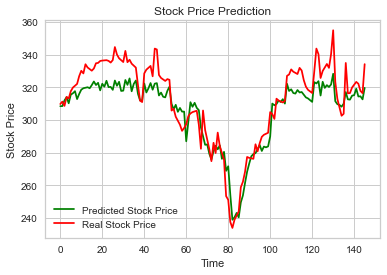

======FINISHED WORKING ON PEP======


In [30]:
train_and_test_model(categories, tickers, prev_open_norm_dfs, unscaled_op_labels)